### Load data and show maps

#### NYC

In [2]:
import numpy as np
import pandas as pd 
import json
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium 
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


In [3]:
# New York neighborhood data
with open('new_york.json') as json_data:
    newyork_data = json.load(json_data)
    
nyneighborhoods = newyork_data['features']

# Name the columns
column_names = ['City','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyneighborhoods:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'City': 'New York',
                                          'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


In [4]:
# Function plots the city map with different neighborhood labels based on Borough
def citymap(cityname,countryname,dataframe):
    # create map
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color for Boroughs
    borough_name = dataframe['Borough'].unique().tolist()
    colnum = dataframe['Borough'].unique().size
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, neighborhood, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Neighborhood'], dataframe['Borough']):
        cluster = borough_name.index(borough)
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
       
    
    return my_map

In [5]:
citymap('New York','USA',ny_neighborhoods)

All the neighorhoods in the same Borough share the same color.

#### Toronto

In [6]:
# Toronto neighborhood data
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wikipage = requests.get(url)
wikipage.text[:100]

# new pandas DataFrame
toronto = pd.DataFrame()

# Read the wikipage
soup = BeautifulSoup(wikipage.text, 'lxml')
wikitable = soup.find_all('table')[0] 

row_marker = 0

for row in wikitable.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        toronto.loc[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

#rename column names
toronto.rename(columns={0:'PostalCode',1:'Borough',2:'Neighborhood'}, inplace=True)
#drop all rows with unassigned borough
toronto = toronto[toronto.Borough!='Not assigned']
toronto.reset_index(drop=True,inplace=True)

#create a new dataframe toronto_neighbor to find all neighborhoods with the location information
toronto_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for ii in range(toronto.shape[0]):
    borough = toronto.loc[ii,'Borough']
    postalcode = toronto.loc[ii,'PostalCode']
    neighborhood = toronto.loc[ii,'Neighborhood'][:-1] #delete the last character \n
    
    #if the neighborhood name is not assigned, than the neighorhood name is same as borough
    if neighborhood == 'Not assigned':
        neighborhood = borough
    
    #find the location data, ignore the neighborhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="mycapstoneproject")
    location = geolocator.geocode("{},{},Toronto,Ontario,Canada".format(neighborhood,borough))
    
    #try one more searching
    if location is None: 
        location = geolocator.geocode("{},Toronto,Ontario,Canada".format(neighborhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        toronto_neighborhoods = toronto_neighborhoods.append({'City': 'Toronto',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

toronto_neighborhoods.head()

The location data of Humewood-Cedarvale in York is not available!
The location data of Caledonia-Fairbanks in York is not available!
The location data of CFB Toronto in North York is not available!
The location data of Del Ray in York is not available!
The location data of North Midtown in Central Toronto is not available!
The location data of Canada Post Gateway Processing Centre in Mississauga is not available!
The location data of Island airport in Downtown Toronto is not available!
The location data of Railway Lands in Downtown Toronto is not available!
The location data of Humber Bay Shores in Etobicoke is not available!
The location data of Beaumond Heights in Etobicoke is not available!
The location data of Stn A PO Boxes 25 The Esplanade in Downtown Toronto is not available!
The location data of Business Reply Mail Processing Centre 969 Eastern in East Toronto is not available!


,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.758800,-79.320197
1,Toronto,North York,Victoria Village,43.732658,-79.311189
2,Toronto,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,Toronto,Downtown Toronto,Regent Park,43.660706,-79.360457
4,Toronto,North York,Lawrence Heights,43.722778,-79.450933


In [7]:
citymap('Toronto','Canada',toronto_neighborhoods)

Three outliers in downtown: Queen's Park, Trinity and Studio District.

In [8]:
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Queen\'s Park']
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Trinity']
toronto_neighborhoods = toronto_neighborhoods[toronto_neighborhoods.Neighborhood != 'Studio District']
toronto_neighborhoods.reset_index(drop=True,inplace=True)
toronto_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.758800,-79.320197
1,Toronto,North York,Victoria Village,43.732658,-79.311189
2,Toronto,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,Toronto,Downtown Toronto,Regent Park,43.660706,-79.360457
4,Toronto,North York,Lawrence Heights,43.722778,-79.450933


In [9]:
citymap('Toronto','Canada',toronto_neighborhoods)

#### Shanghai

In [10]:
sh = pd.read_csv('Shanghai.csv')
sh.rename(columns={'District':'Borough','Subdistrict':'Neighborhood'}, inplace=True)
sh.head()

,City,Borough,Neighborhood
0,Shanghai,Baoshan,Wusong
1,Shanghai,Baoshan,Youyi
2,Shanghai,Baoshan,Zhangmiao
3,Shanghai,Baoshan,Dachang
4,Shanghai,Baoshan,Gaojing


In [11]:
# New dataframe: sh_neighbor
sh_neighborhoods= pd.DataFrame(columns = ['City','Borough','Neighborhood'])

for borough, neighborhood in zip(sh['Borough'],sh['Neighborhood']):   
    # Ignore the neighborhoods that are unable to be located by Nominatim
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode("{},{},Shanghai,China".format(neighborhood,borough))

    if location is None: 
        location = geolocator.geocode("{},Shanghai,China".format(neighborhood))
        
    if location is None: 
        print("The location data of {} in {} is not available!".format(neighborhood,borough))
    else:
        sh_neighborhoods = sh_neighborhoods.append({'City': 'Shanghai',
                                                'Borough': borough,
                                                'Neighborhood': neighborhood,
                                                'Latitude': location.latitude,
                                                'Longitude': location.longitude
                                               }, ignore_index=True)

sh_neighborhoods.head()

The location data of Miaohang in Baoshan is not available!
The location data of Xianhua in Changning is not available!
The location data of Zhoujiaqiao in Changning is not available!
The location data of Shanghai Fengxian Bay Tourism Zone in Fengxian is not available!
The location data of Shanghai Seaport Comprehensive Economic Development Zone in Fengxian is not available!
The location data of Jiangwanzhen in Hongkou is not available!
The location data of Ruijin Second Road in Huangpu is not available!
The location data of Xiaodongmen in Huangpu is not available!
The location data of Jiadingzhen in Jiading is not available!
The location data of Juyuan New Area Administrative Committee in Jiading is not available!
The location data of Zhenxin in Jiading is not available!
The location data of Waigang in Jiading is not available!
The location data of Xuhang in Jiading is not available!
The location data of Jingansi in Jingan is not available!
The location data of Shimen Second Road in Ji

,City,Borough,Neighborhood,Latitude,Longitude
0,Shanghai,Baoshan,Wusong,31.374707,121.489410
1,Shanghai,Baoshan,Youyi,31.405927,121.471382
2,Shanghai,Baoshan,Zhangmiao,31.335766,121.440917
3,Shanghai,Baoshan,Dachang,31.294144,121.412396
4,Shanghai,Baoshan,Gaojing,31.323159,121.477525


In [12]:
citymap('Shanghai','China',sh_neighborhoods)

In [13]:
drop = ['Chenjia','Xinhe','Xincun','Zhongxing','Changzheng','Beizhan','Chaoyang Farm']

for neighborhoods in drop:
    sh_neighborhoods = sh_neighborhoods[sh_neighborhoods.Neighborhood != neighborhoods]
    sh_neighborhoods.reset_index(drop=True,inplace=True)
    
citymap('Shanghai','China',sh_neighborhoods)

In [14]:
ny_neighborhoods.to_csv('ny_neighborhoods.csv', sep='\t')
toronto_neighborhoods.to_csv('toronto_neighborhoods.csv', sep='\t')
sh_neighborhoods.to_csv('sh_neighborhoods.csv', sep='\t')

### Nearby Venues

#### NYC

In [15]:
ny_neighborhoods.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


In [18]:
LIMIT = 50 # only return the top 100 venues
CLIENT_ID = '0MJA3NYYG3U2ZY1LTZN2OYEHS3Y3WVSON2GBSO3IL4EDYVIR' # Foursquare ID
CLIENT_SECRET = 'WGWSAF2TKVUQPE3PD0N3EOITFVBY5EYP1VCZI3BMUG0ROUS5' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

# define a function to expore each city in radius of 1000 meters
def getNearbyVenues(nborhood, radius=1000):
    
    venues=pd.DataFrame(columns=['City','Borough','Neighborhood','VenueName','VenueCategory'])
    for city, borough, neighborhood, lat, lng in zip(nborhood['City'], nborhood['Borough'], nborhood['Neighborhood'], nborhood['Latitude'], nborhood['Longitude']):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        if results is not None:
            for v in results:
                venues = venues.append({'City':city, 'Borough':borough, 'Neighborhood': neighborhood, 
                           'VenueName': v['venue']['name'], 
                           'VenueCategory': v['venue']['categories'][0]['name']},ignore_index=True)

   
    
    return(venues)

In [19]:
# Nearby venues of each neighborhood in New York
ny_venues = getNearbyVenues(ny_neighborhoods)
ny_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant
3,New York,Bronx,Wakefield,Rite Aid,Pharmacy
4,New York,Bronx,Wakefield,Jackie's West Indian Bakery,Caribbean Restaurant


In [20]:
# save the data
ny_venues.to_csv('ny_venues.csv', sep='\t')
ny_venues.shape

(13382, 5)

In [21]:
# Avoid multi-index problem
ny_venues = ny_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})

Total of 13382 venues available in New York.

#### Toronto

In [22]:
toronto_venues = getNearbyVenues(toronto_neighborhoods)
toronto_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,Toronto,North York,Parkwoods,Allwyn's Bakery,Caribbean Restaurant
1,Toronto,North York,Parkwoods,LCBO,Liquor Store
2,Toronto,North York,Parkwoods,Tim Hortons,Café
3,Toronto,North York,Parkwoods,A&W Canada,Fast Food Restaurant
4,Toronto,North York,Parkwoods,Dollarama,Discount Store


In [23]:
toronto_venues.to_csv('toronto_venues.csv', sep='\t')

# Avoid multi-index problem
toronto_venues = toronto_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
toronto_venues.shape

(6646, 5)

#### Shanghai

In [24]:
sh_venues = getNearbyVenues(sh_neighborhoods)
sh_venues.head()

,City,Borough,Neighborhood,VenueName,VenueCategory
0,Shanghai,Baoshan,Wusong,Songbin Road Metro Station (淞滨路地铁站),Metro Station
1,Shanghai,Baoshan,Wusong,吴淞码头,General Travel
2,Shanghai,Baoshan,Wusong,Bund 1919 Art Area,Plaza
3,Shanghai,Baoshan,Wusong,新长江大酒店,Hotel
4,Shanghai,Baoshan,Youyi,McDonald's (麦当劳),Fast Food Restaurant


In [25]:
sh_venues.to_csv('sh_venues.csv', sep='\t')

# Avoid multi-index problem
sh_venues = sh_venues.rename(columns={'Neighborhood': 'NeighborhoodName'})
sh_venues.shape

(2389, 5)

#### Concat all three datasets into one dataframe

In [26]:
# Concat them
allvenues =  pd.concat([ny_venues, toronto_venues, sh_venues])
allvenues = allvenues.rename(columns={'Neighborhood': 'NeighborhoodName'})
allvenues.shape

(22417, 5)

In [27]:
allvenues.head()

,City,Borough,NeighborhoodName,VenueName,VenueCategory
0,New York,Bronx,Wakefield,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,Ripe Kitchen & Bar,Caribbean Restaurant
2,New York,Bronx,Wakefield,Ali's Roti Shop,Caribbean Restaurant
3,New York,Bronx,Wakefield,Rite Aid,Pharmacy
4,New York,Bronx,Wakefield,Jackie's West Indian Bakery,Caribbean Restaurant


In [28]:
allvenues.to_csv('allvenues.csv', sep='\t')

In [29]:
# Concat neighborhoods
allneighborhoods =  pd.concat([ny_neighborhoods, toronto_neighborhoods, sh_neighborhoods])
allneighborhoods = allneighborhoods.rename(columns={'Neighborhood': 'NeighborhoodName'})
allneighborhoods.shape

(693, 5)

In [30]:
allneighborhoods.head()

,City,Borough,NeighborhoodName,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


In [31]:
allneighborhoods.to_csv('allneighborhoods.csv', sep='\t')

#### Group venues based on categories.
#### Calculate the total number of venues of each category.

In [32]:
# get dummies
allvenues_onehot = pd.get_dummies(allvenues, columns = ['VenueCategory'], prefix="", prefix_sep="")
allvenues_onehot = allvenues_onehot.drop('VenueName',axis = 1)
# allvenues_onehot.columns.values

In [33]:
# Group the venues based on Neighborhoods
allvenues_grouped = allvenues_onehot.groupby('NeighborhoodName',axis = 0).sum().reset_index()
allvenues_grouped = allneighborhoods.join(allvenues_grouped.set_index('NeighborhoodName'), on='NeighborhoodName')

# Drop the rows with NaN
allvenues_grouped.dropna(inplace=True)
allvenues_grouped.head()

,City,Borough,NeighborhoodName,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,...,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,New York,Bronx,Wakefield,40.894705,-73.847201,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,New York,Bronx,Co-op City,40.874294,-73.829939,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,New York,Bronx,Eastchester,40.887556,-73.827806,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,New York,Bronx,Fieldston,40.895437,-73.905643,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,New York,Bronx,Riverdale,40.890834,-73.912585,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# New dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
columns = ['City','Borough','NeighborhoodName','Latitude','Longitude','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# Create columns according to number of top venues
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
allvenues_sorted = pd.DataFrame(columns = columns)
#allvenues_sorted = allvenues_grouped[['City','Borough','NeighborhoodName']]

for ind in range(allvenues_grouped.shape[0]):
    allvenues_sorted.loc[ind, 'City'] = allvenues_grouped.iloc[ind].City
    allvenues_sorted.loc[ind, 'Borough'] = allvenues_grouped.iloc[ind].Borough
    allvenues_sorted.loc[ind, 'NeighborhoodName'] = allvenues_grouped.iloc[ind].NeighborhoodName
    allvenues_sorted.loc[ind, 'Latitude'] = allvenues_grouped.iloc[ind].Latitude
    allvenues_sorted.loc[ind, 'Longitude'] = allvenues_grouped.iloc[ind].Longitude
    allvenues_sorted.loc[ind, 'Total Number of Venues'] = allvenues_grouped.iloc[ind,5:].sum()
    allvenues_sorted.iloc[ind, 6:] = return_most_common_venues(allvenues_grouped.iloc[ind, 5:], num_top_venues)

allvenues_sorted.head()

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,Bronx,Wakefield,40.8947,-73.8472,45,Caribbean Restaurant,Pharmacy,Gas Station,Donut Shop,Fast Food Restaurant,Supermarket,Bank,Chinese Restaurant,Fried Chicken Joint,Burger Joint
1,New York,Bronx,Co-op City,40.8743,-73.8299,50,Mobile Phone Shop,Shopping Mall,Bakery,Pharmacy,Discount Store,Shoe Store,Pizza Place,Department Store,Mexican Restaurant,Kids Store
2,New York,Bronx,Eastchester,40.8876,-73.8278,50,Diner,Shopping Mall,Fast Food Restaurant,Caribbean Restaurant,Supplement Shop,Donut Shop,Discount Store,Mobile Phone Shop,Asian Restaurant,Women's Store
3,New York,Bronx,Fieldston,40.8954,-73.9056,45,Pizza Place,Sandwich Place,Bus Station,Park,Deli / Bodega,Mexican Restaurant,Bank,Plaza,Bar,Coffee Shop
4,New York,Bronx,Riverdale,40.8908,-73.9126,94,Coffee Shop,Bar,Vietnamese Restaurant,Pizza Place,Bakery,Café,Park,Bank,Diner,Vegetarian / Vegan Restaurant


#### I use hierarchical agglomerative clustering method to compare neighborhoods among cities so that I could find the number of clusters.

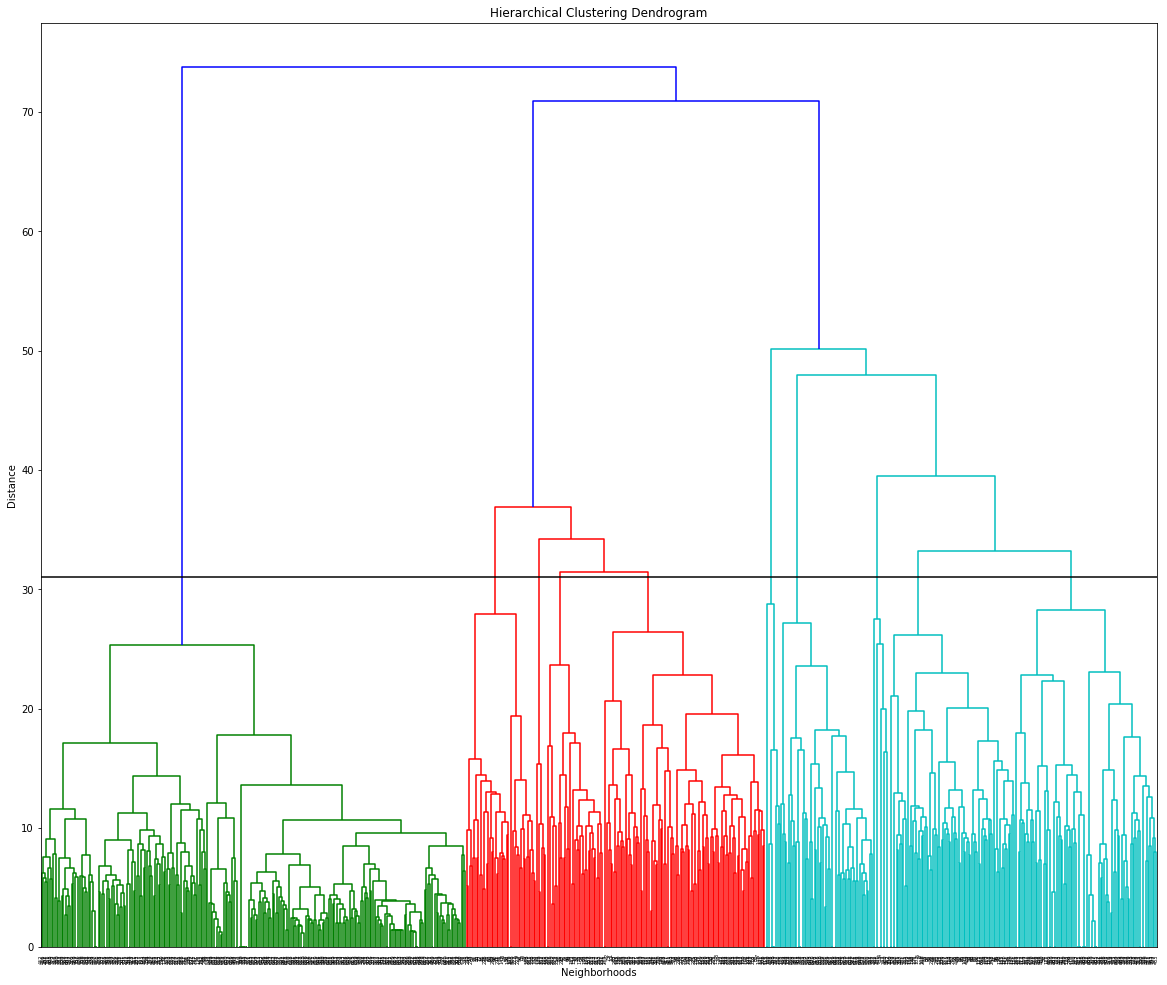

In [35]:
import scipy.cluster.hierarchy as shc

data = allvenues_grouped.iloc[:,6:]
plt.figure(figsize=(20, 17))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=31, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward')) 

#### I decide to separate our neighborhoods into nine clusters due to that horizontal cutting line at distance of 31.

In [36]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)  

In [37]:
allvenues_sorted['Cluster_Labels'] = clusterresult

In [38]:
# Define a function to show the neighborhoods with same cluster labels
def clustermap(cityname,countryname,dataframe):
    # create map
    address = cityname + ',' + countryname
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    my_map = folium.Map(location=[latitude, longitude], zoom_start=10)
    # set color scheme for the Cluster_Labels
    colnum = 9
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    # add markers to the map
    for lat, lon, neighborhood, borough, cluster_labels in zip(dataframe['Latitude'], 
                                                               dataframe['Longitude'], 
                                                               dataframe['NeighborhoodName'], 
                                                               dataframe['Borough'],
                                                               dataframe['Cluster_Labels']):
        cluster = cluster_labels 
        label = '{}, {},Cluster:{}'.format(neighborhood, borough,cluster_labels)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(my_map)
    return my_map

In [39]:
for ii in range(9):
    num = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == ii].shape[0]
    print('Total number of neighborhoods in cluster {} is {}'.format(ii, num))

Total number of neighborhoods in cluster 0 is 131
Total number of neighborhoods in cluster 1 is 9
Total number of neighborhoods in cluster 2 is 85
Total number of neighborhoods in cluster 3 is 75
Total number of neighborhoods in cluster 4 is 55
Total number of neighborhoods in cluster 5 is 10
Total number of neighborhoods in cluster 6 is 42
Total number of neighborhoods in cluster 7 is 6
Total number of neighborhoods in cluster 8 is 254


### Now let's find out what's the hidden info behind each clusters.

#### Cluster 0

In [40]:
cluster0 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 0]
cluster0

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
1,New York,Bronx,Co-op City,40.8743,-73.8299,50,Mobile Phone Shop,Shopping Mall,Bakery,Pharmacy,Discount Store,Shoe Store,Pizza Place,Department Store,Mexican Restaurant,Kids Store,0
2,New York,Bronx,Eastchester,40.8876,-73.8278,50,Diner,Shopping Mall,Fast Food Restaurant,Caribbean Restaurant,Supplement Shop,Donut Shop,Discount Store,Mobile Phone Shop,Asian Restaurant,Women's Store,0
3,New York,Bronx,Fieldston,40.8954,-73.9056,45,Pizza Place,Sandwich Place,Bus Station,Park,Deli / Bodega,Mexican Restaurant,Bank,Plaza,Bar,Coffee Shop,0
7,New York,Bronx,Woodlawn,40.8983,-73.8673,50,Pub,Deli / Bodega,Bar,Discount Store,Italian Restaurant,Pizza Place,Bakery,American Restaurant,Bank,Donut Shop,0
10,New York,Bronx,Baychester,40.8669,-73.8358,50,Department Store,Clothing Store,Discount Store,Pharmacy,Kids Store,Shopping Mall,Mexican Restaurant,Pizza Place,Italian Restaurant,Spanish Restaurant,0
11,New York,Bronx,Pelham Parkway,40.8574,-73.8548,50,Pizza Place,Donut Shop,Italian Restaurant,Bank,Sandwich Place,Supermarket,Gas Station,Burger Joint,Bakery,Pharmacy,0
16,New York,Bronx,Fordham,40.861,-73.8964,50,Italian Restaurant,Pizza Place,Diner,Gym,Dessert Shop,Chinese Restaurant,Mobile Phone Shop,Shoe Store,Plaza,Deli / Bodega,0
22,New York,Bronx,Port Morris,40.8017,-73.9132,44,Baseball Field,Donut Shop,Grocery Store,Pizza Place,Restaurant,Coffee Shop,Discount Store,Distillery,Pharmacy,Gym,0
26,New York,Bronx,Soundview,40.821,-73.8657,50,Fast Food Restaurant,Fried Chicken Joint,Breakfast Spot,Clothing Store,Supermarket,Park,Department Store,Deli / Bodega,Mobile Phone Shop,Gas Station,0
28,New York,Bronx,Throgs Neck,40.8151,-73.8164,31,Italian Restaurant,Deli / Bodega,Donut Shop,Pizza Place,Asian Restaurant,Japanese Restaurant,Harbor / Marina,Beach,Bar,Trail,0


In [41]:
clustermap('New York', 'USA', cluster0)

In [42]:
clustermap('Toronto','Canada',cluster0[cluster0['City'] == 'Toronto'])

Cluster 0 contains a lot of restaurants and bars. Mostly Italian restaurants, coffee shop and bars. Basically the downtown areas where people grab quality food are covered.

#### Cluster 1

In [44]:
cluster1 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 1]
cluster1

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
115,New York,Manhattan,Murray Hill,40.7483,-73.9783,100,Korean Restaurant,Coffee Shop,Sandwich Place,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pub,Karaoke Bar,Sushi Restaurant,Supermarket,1
152,New York,Queens,Auburndale,40.7617,-73.7918,50,Korean Restaurant,Pharmacy,Cosmetics Shop,Pizza Place,Café,Gym / Fitness Center,Diner,Greek Restaurant,Sushi Restaurant,Ice Cream Shop,1
180,New York,Queens,Murray Hill,40.7641,-73.8128,100,Korean Restaurant,Coffee Shop,Sandwich Place,Gym / Fitness Center,Japanese Restaurant,Pizza Place,Pub,Karaoke Bar,Sushi Restaurant,Supermarket,1
250,New York,Manhattan,Midtown South,40.7485,-73.9887,50,Korean Restaurant,Hotel,Lingerie Store,Cosmetics Shop,Coffee Shop,Yoga Studio,Japanese Restaurant,Dessert Shop,Gym / Fitness Center,Cocktail Bar,1
358,Toronto,North York,Fairview,43.7708,-79.4133,50,Korean Restaurant,Ramen Restaurant,Sushi Restaurant,Coffee Shop,Bubble Tea Shop,Restaurant,Japanese Restaurant,Café,Indonesian Restaurant,Sports Bar,1
397,Toronto,North York,Newtonbrook,43.7939,-79.4257,50,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Café,Grocery Store,Bank,Pet Store,Hobby Shop,Auto Dealership,Toy / Game Store,1
398,Toronto,North York,Willowdale,43.7754,-79.4167,50,Korean Restaurant,Bubble Tea Shop,Ramen Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Café,Burrito Place,Sushi Restaurant,Movie Theater,1
409,Toronto,North York,Willowdale South,43.7754,-79.4167,50,Korean Restaurant,Bubble Tea Shop,Ramen Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Café,Burrito Place,Sushi Restaurant,Movie Theater,1
428,Toronto,North York,Willowdale West,43.7754,-79.4167,50,Korean Restaurant,Bubble Tea Shop,Ramen Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Café,Burrito Place,Sushi Restaurant,Movie Theater,1


In [45]:
clustermap('New York','USA',cluster1[cluster1['City'] == 'New York'])

In [46]:
clustermap('Toronto','Canada',cluster1[cluster1['City'] == 'Toronto'])

Cluster 1 contains almost all the Korean restaurants both in Toronto and NYC!

#### Cluster 2

In [47]:
cluster2 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 2]
cluster2

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
52,New York,Brooklyn,Sheepshead Bay,40.5869,-73.9432,50,Italian Restaurant,Turkish Restaurant,Sushi Restaurant,Pizza Place,Sandwich Place,Dessert Shop,Restaurant,Bar,Café,Russian Restaurant,2
64,New York,Brooklyn,Brooklyn Heights,40.6959,-73.9938,50,Park,Italian Restaurant,Yoga Studio,Pet Store,Gym,Coffee Shop,Ice Cream Shop,American Restaurant,Scenic Lookout,Burger Joint,2
77,New York,Brooklyn,Manhattan Beach,40.5779,-73.9435,50,Italian Restaurant,Turkish Restaurant,Dessert Shop,Sandwich Place,Seafood Restaurant,Eastern European Restaurant,Pizza Place,Restaurant,Bar,Russian Restaurant,2
107,New York,Manhattan,Upper East Side,40.7756,-73.9605,50,Gym / Fitness Center,Bakery,Exhibit,Hotel,Spa,Yoga Studio,Italian Restaurant,Art Museum,American Restaurant,Jazz Club,2
109,New York,Manhattan,Lenox Hill,40.7681,-73.9589,50,Gym / Fitness Center,Sushi Restaurant,Italian Restaurant,Gym,Burger Joint,Coffee Shop,Café,Bakery,Cocktail Bar,Thai Restaurant,2
110,New York,Manhattan,Roosevelt Island,40.7622,-73.9492,50,Park,Greek Restaurant,Sushi Restaurant,Liquor Store,Pizza Place,Bakery,Coffee Shop,Tram Station,Salad Place,Cocktail Bar,2
112,New York,Manhattan,Lincoln Square,40.7735,-73.9853,50,Gym / Fitness Center,Concert Hall,Plaza,Performing Arts Venue,Theater,Indie Movie Theater,Hotel,Bakery,Cycle Studio,Opera House,2
113,New York,Manhattan,Clinton,40.7591,-73.9961,50,Theater,Gym / Fitness Center,Bakery,Burger Joint,Sandwich Place,American Restaurant,Wine Shop,Indie Theater,Gym,Hotel,2
114,New York,Manhattan,Midtown,40.7547,-73.9817,50,Theater,Cuban Restaurant,Cycle Studio,Gym,Sandwich Place,Coffee Shop,Hotel,Sporting Goods Shop,Italian Restaurant,Grocery Store,2
116,New York,Manhattan,Chelsea,40.744,-74.0031,88,Hotel,American Restaurant,Ice Cream Shop,Italian Restaurant,Coffee Shop,Seafood Restaurant,Spanish Restaurant,Park,Baseball Field,Bus Stop,2


In [48]:
clustermap('New York','USA',cluster2[cluster2['City'] == 'New York'])

In [49]:
clustermap('Toronto','Canada',cluster2[cluster2['City'] == 'Toronto'])

Cluster 2 contains mostly bars, coffee shops, pizza shops and almost all kinds of popular restaurants from different countries such as Japanese cuisines.

#### Cluster 3

In [50]:
cluster3 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 3]
cluster3

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
5,New York,Bronx,Kingsbridge,40.8817,-73.9028,50,Pizza Place,Mexican Restaurant,Donut Shop,Japanese Restaurant,Bar,Bakery,Coffee Shop,Diner,Spanish Restaurant,Burger Joint,3
6,New York,Manhattan,Marble Hill,40.8766,-73.9107,50,Pizza Place,Mexican Restaurant,Café,Sandwich Place,Coffee Shop,Discount Store,Supermarket,Park,Donut Shop,Supplement Shop,3
12,New York,Bronx,City Island,40.8472,-73.7865,45,Harbor / Marina,Seafood Restaurant,Italian Restaurant,Boat or Ferry,Thrift / Vintage Store,Grocery Store,Bar,Ice Cream Shop,American Restaurant,History Museum,3
35,New York,Bronx,Spuyten Duyvil,40.8814,-73.9172,50,Park,Pharmacy,Pizza Place,Bank,Café,Deli / Bodega,Mexican Restaurant,Sandwich Place,Diner,Thai Restaurant,3
48,New York,Brooklyn,Sunset Park,40.6451,-74.0103,50,Bakery,Mexican Restaurant,Latin American Restaurant,Pizza Place,Bank,Chinese Restaurant,Vietnamese Restaurant,Café,Spanish Restaurant,Seafood Restaurant,3
49,New York,Brooklyn,Greenpoint,40.7302,-73.9542,50,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Café,Yoga Studio,Mexican Restaurant,French Restaurant,Bakery,Boutique,3
54,New York,Brooklyn,Flatbush,40.6363,-73.9584,50,Caribbean Restaurant,Mexican Restaurant,Bar,Coffee Shop,Pizza Place,Café,Middle Eastern Restaurant,Deli / Bodega,Health Food Store,Discount Store,3
55,New York,Brooklyn,Crown Heights,40.6708,-73.9433,50,Café,Coffee Shop,Pizza Place,Caribbean Restaurant,Cocktail Bar,Museum,Juice Bar,Bakery,Sushi Restaurant,Salon / Barbershop,3
57,New York,Brooklyn,Kensington,40.6424,-73.9804,50,Thai Restaurant,Pizza Place,Ice Cream Shop,Café,Grocery Store,Mexican Restaurant,Sandwich Place,Bakery,Lingerie Store,Pharmacy,3
58,New York,Brooklyn,Windsor Terrace,40.6569,-73.9801,50,Wine Shop,Café,Park,Bar,Deli / Bodega,Italian Restaurant,Playground,Diner,Music Venue,Baseball Field,3


In [51]:
clustermap('New York','USA',cluster3[cluster3['City'] == 'New York'])

In [52]:
clustermap('Toronto','Canada',cluster3[cluster3['City'] == 'Toronto'])

Cluster 3 contains mostly fast food restaurants in NYC and Toronto. Other than that, some other rare exotic cuisines like Caribbean and Indian cuisines are also among the list as well.

#### Cluster 4

In [53]:
## cluster 4
cluster4 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 4]
cluster4

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
138,New York,Queens,Flushing,40.7645,-73.8318,50,Chinese Restaurant,Bubble Tea Shop,Hotpot Restaurant,Dumpling Restaurant,Bakery,Food Court,Cantonese Restaurant,Tea Room,Asian Restaurant,Pizza Place,4
139,New York,Queens,Long Island City,40.7502,-73.9392,50,Hotel,Coffee Shop,Mexican Restaurant,Italian Restaurant,Café,Climbing Gym,Pizza Place,Art Museum,Bar,Indian Restaurant,4
184,New York,Queens,Queensboro Hill,40.7446,-73.8258,50,Chinese Restaurant,Bakery,Bank,Flower Shop,Supermarket,Asian Restaurant,Dumpling Restaurant,Malay Restaurant,Bagel Shop,Food Truck,4
304,New York,Queens,Queensbridge,40.7561,-73.9456,50,Hotel,Coffee Shop,Mexican Restaurant,Italian Restaurant,Greek Restaurant,Brewery,Park,Bar,Climbing Gym,Tennis Court,4
308,Toronto,Downtown Toronto,Harbourfront,43.6401,-79.3801,50,Hotel,Park,Coffee Shop,Café,Fried Chicken Joint,Aquarium,Brewery,Scenic Lookout,Lounge,Bar,4
362,Toronto,North York,York University,43.7706,-79.5008,34,Coffee Shop,Pizza Place,Metro Station,Shopping Mall,Tennis Stadium,Restaurant,Smoothie Shop,Chinese Restaurant,Park,Grocery Store,4
364,Toronto,Downtown Toronto,Harbourfront East,43.6401,-79.3801,50,Hotel,Park,Coffee Shop,Café,Fried Chicken Joint,Aquarium,Brewery,Scenic Lookout,Lounge,Bar,4
438,Toronto,Scarborough,Agincourt,43.7854,-79.2785,34,Chinese Restaurant,Restaurant,Cantonese Restaurant,Shopping Mall,Park,Hotel,Pharmacy,Asian Restaurant,Pet Store,Liquor Store,4
454,Toronto,Scarborough,Milliken,43.8232,-79.3015,50,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Bakery,Bubble Tea Shop,Hong Kong Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Bank,4
461,Toronto,Downtown Toronto,CN Tower,43.6426,-79.3871,50,Hotel,Italian Restaurant,Aquarium,Bar,Scenic Lookout,Baseball Stadium,Park,Theater,Salad Place,Train Station,4


In [54]:
clustermap('New York','USA',cluster4[cluster4['City'] == 'New York'])

In [55]:
clustermap('Toronto','Canada',cluster4[cluster4['City'] == 'Toronto'])

Cluster 4 contains almost all of the quality bars in NYC and Toronto, in which areas like Flushing are included as well. 

#### Cluster 5

In [56]:
# cluster 5
cluster5 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 5]
cluster5

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
4,New York,Bronx,Riverdale,40.8908,-73.9126,94,Coffee Shop,Bar,Vietnamese Restaurant,Pizza Place,Bakery,Café,Park,Bank,Diner,Vegetarian / Vegan Restaurant,5
13,New York,Bronx,Bedford Park,40.8702,-73.8855,100,Coffee Shop,Pizza Place,Diner,Sandwich Place,Pub,Park,Bakery,Sushi Restaurant,Café,Supermarket,5
108,New York,Manhattan,Yorkville,40.7759,-73.9471,100,Italian Restaurant,Coffee Shop,Park,Ice Cream Shop,Gym,Restaurant,Deli / Bodega,Japanese Restaurant,Boutique,Sandwich Place,5
332,Toronto,Downtown Toronto,St. James Town,43.6626,-79.3764,100,Coffee Shop,Japanese Restaurant,Gastropub,Park,Gay Bar,Diner,Ramen Restaurant,Pizza Place,Pub,Theater,5
374,Toronto,East Toronto,Riverdale,43.6655,-79.3526,94,Coffee Shop,Bar,Vietnamese Restaurant,Pizza Place,Bakery,Café,Park,Bank,Diner,Vegetarian / Vegan Restaurant,5
400,Toronto,North York,Bedford Park,43.7374,-79.4109,100,Coffee Shop,Pizza Place,Diner,Sandwich Place,Pub,Park,Bakery,Sushi Restaurant,Café,Supermarket,5
414,Toronto,York,Runnymede,43.6635,-79.4895,100,Coffee Shop,Café,Bakery,Pizza Place,Italian Restaurant,Pub,Park,Sushi Restaurant,Bank,Restaurant,5
431,Toronto,Central Toronto,Yorkville,43.6714,-79.3902,100,Italian Restaurant,Coffee Shop,Park,Ice Cream Shop,Gym,Restaurant,Deli / Bodega,Japanese Restaurant,Boutique,Sandwich Place,5
442,Toronto,West Toronto,Runnymede,43.6518,-79.4759,100,Coffee Shop,Café,Bakery,Pizza Place,Italian Restaurant,Pub,Park,Sushi Restaurant,Bank,Restaurant,5
482,Toronto,Downtown Toronto,St. James Town,43.6626,-79.3764,100,Coffee Shop,Japanese Restaurant,Gastropub,Park,Gay Bar,Diner,Ramen Restaurant,Pizza Place,Pub,Theater,5


In [57]:
clustermap('New York','USA',cluster5[cluster5['City'] == 'New York'])

In [58]:
clustermap('Toronto','Canada',cluster5[cluster5['City'] == 'Toronto'])

In [59]:
clustermap('Shanghai','China',cluster5[cluster5['City'] == 'Shanghai'])

Cluster 5 contains mostly Chinese restaurants in NYC, Toronto and of course, Shanghai.

#### Cluster 6


In [60]:
## cluster 6
cluster6 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 6]
cluster6

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
0,New York,Bronx,Wakefield,40.8947,-73.8472,45,Caribbean Restaurant,Pharmacy,Gas Station,Donut Shop,Fast Food Restaurant,Supermarket,Bank,Chinese Restaurant,Fried Chicken Joint,Burger Joint,6
8,New York,Bronx,Norwood,40.8772,-73.8794,50,Pizza Place,Bank,Park,Pharmacy,Donut Shop,Spanish Restaurant,Mexican Restaurant,Mobile Phone Shop,Caribbean Restaurant,Diner,6
9,New York,Bronx,Williamsbridge,40.881,-73.8574,50,Caribbean Restaurant,Pizza Place,Sandwich Place,Supermarket,Fried Chicken Joint,Discount Store,Pharmacy,Gym,Bakery,Soup Place,6
14,New York,Bronx,University Heights,40.8557,-73.9104,50,Grocery Store,Pizza Place,Fried Chicken Joint,Supermarket,Spanish Restaurant,Donut Shop,Sandwich Place,African Restaurant,Latin American Restaurant,Ice Cream Shop,6
15,New York,Bronx,Morris Heights,40.8479,-73.9197,50,Pizza Place,Pharmacy,Supermarket,Grocery Store,Food,Food Truck,Gym / Fitness Center,Spanish Restaurant,Deli / Bodega,Fast Food Restaurant,6
17,New York,Bronx,East Tremont,40.8427,-73.8874,50,Pizza Place,Zoo Exhibit,Donut Shop,Park,Sandwich Place,Bank,Fast Food Restaurant,Lounge,Zoo,Mobile Phone Shop,6
18,New York,Bronx,West Farms,40.8395,-73.8777,50,Park,Zoo Exhibit,Zoo,Donut Shop,Fried Chicken Joint,Pizza Place,Lounge,Fast Food Restaurant,Sandwich Place,Bus Station,6
20,New York,Bronx,Melrose,40.8198,-73.9094,50,Mexican Restaurant,Pizza Place,Art Gallery,Discount Store,Kids Store,Supermarket,Pharmacy,Gym / Fitness Center,Diner,Gym,6
21,New York,Bronx,Mott Haven,40.8062,-73.9161,50,Pizza Place,Mexican Restaurant,Donut Shop,Discount Store,Park,Supermarket,Gym,Grocery Store,Peruvian Restaurant,Burger Joint,6
23,New York,Bronx,Longwood,40.8151,-73.8958,50,Fast Food Restaurant,Donut Shop,Sandwich Place,Discount Store,Pizza Place,Pharmacy,Grocery Store,Latin American Restaurant,Fried Chicken Joint,Diner,6


In [61]:
clustermap('New York','USA',cluster6[cluster6['City'] == 'New York'])

In [62]:
clustermap('Toronto','Canada',cluster6[cluster6['City'] == 'Toronto'])

Cluster 6 includes mostly the coffee shops within NYC and Toronto.

#### Cluster 7

In [63]:
# cluster 7
cluster7 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 7]
cluster7

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
78,New York,Brooklyn,Coney Island,40.5743,-73.9887,50,Theme Park Ride / Attraction,Beach,Ice Cream Shop,Theme Park,Pizza Place,Hot Dog Joint,Caribbean Restaurant,Arcade,Brewery,Gift Shop,7
178,New York,Queens,Rockaway Beach,40.5828,-73.8224,50,Beach,Bar,Brazilian Restaurant,Beach Bar,Eastern European Restaurant,Supermarket,Bagel Shop,Ice Cream Shop,Pizza Place,Wine Bar,7
179,New York,Queens,Neponsit,40.572,-73.8575,25,Beach,Spa,Bus Stop,Deli / Bodega,Pub,Pizza Place,Ice Cream Shop,Park,Harbor / Marina,Boutique,7
190,New York,Queens,Belle Harbor,40.5762,-73.854,24,Beach,Italian Restaurant,Ice Cream Shop,Spa,Mexican Restaurant,Harbor / Marina,Bakery,Bagel Shop,Chinese Restaurant,Donut Shop,7
191,New York,Queens,Rockaway Park,40.5803,-73.8415,50,Beach,Pizza Place,Donut Shop,Bar,Bank,Ice Cream Shop,Deli / Bodega,Bagel Shop,Chinese Restaurant,Bakery,7
302,New York,Queens,Hammels,40.5873,-73.8055,50,Beach,Surf Spot,Wine Bar,Bar,Donut Shop,Board Shop,Coffee Shop,Beach Bar,Pizza Place,Supermarket,7


In [64]:
clustermap('New York','USA',cluster7[cluster7['City'] == 'New York'])

Cluster 7 only contains restaurants in NYC, mostly south and east regions.

## cluster 8

In [65]:
## cluster 8
cluster8 = allvenues_sorted[allvenues_sorted['Cluster_Labels'] == 8]
cluster8

,City,Borough,NeighborhoodName,Latitude,Longitude,Total Number of Venues,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Labels
19,New York,Bronx,High Bridge,40.8366,-73.9261,46,Lounge,Baseball Stadium,Sandwich Place,Burger Joint,Plaza,Historic Site,Chinese Restaurant,Caribbean Restaurant,Athletics & Sports,Gas Station,8
24,New York,Bronx,Hunts Point,40.8097,-73.8833,27,Food,Construction & Landscaping,Bakery,Seafood Restaurant,Park,Pool,Travel & Transport,Coffee Shop,Farmers Market,Pizza Place,8
27,New York,Bronx,Clason Point,40.8066,-73.8541,5,Park,Gym / Fitness Center,Discount Store,Bus Station,Zoo Exhibit,Filipino Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,8
51,New York,Brooklyn,Brighton Beach,40.5768,-73.9651,50,Supermarket,Beach,Russian Restaurant,Sushi Restaurant,Eastern European Restaurant,Bakery,Restaurant,Aquarium,Mobile Phone Shop,Neighborhood,8
72,New York,Brooklyn,East New York,40.6699,-73.8807,24,Sandwich Place,Pizza Place,Supermarket,Metro Station,Grocery Store,Playground,Bakery,Chinese Restaurant,Donut Shop,Discount Store,8
76,New York,Brooklyn,Mill Island,40.6063,-73.9082,24,Burger Joint,Gym,Harbor / Marina,Pizza Place,Bakery,Boat or Ferry,Tourist Information Center,Shopping Mall,Hardware Store,BBQ Joint,8
85,New York,Brooklyn,Sea Gate,40.5764,-74.0079,17,Beach,Supermarket,Bus Station,Fried Chicken Joint,Basketball Court,Donut Shop,Pharmacy,Home Service,Pizza Place,Spa,8
91,New York,Brooklyn,Bergen Beach,40.6151,-73.8986,11,Donut Shop,Peruvian Restaurant,American Restaurant,Stables,Liquor Store,Pizza Place,Playground,Deli / Bodega,Supermarket,Italian Restaurant,8
164,New York,Queens,South Jamaica,40.6969,-73.7904,29,Pizza Place,Park,Discount Store,Deli / Bodega,Bank,Bus Stop,Mobile Phone Shop,Grocery Store,Caribbean Restaurant,Sandwich Place,8
167,New York,Queens,Springfield Gardens,40.6662,-73.7604,31,Bus Station,Donut Shop,Caribbean Restaurant,Park,Gym,Pizza Place,Deli / Bodega,Fried Chicken Joint,Shoe Store,Clothing Store,8


In [66]:
clustermap('New York','USA',cluster8[cluster8['City'] == 'New York'])

In [67]:
clustermap('Toronto','Canada',cluster8[cluster8['City'] == 'Toronto'])

In [68]:
clustermap('Shanghai','China',cluster8[cluster8['City'] == 'Shanghai'])

Cluster 8 contains some recreational public places like parks ,hotels, shopping malls and coffee shops, bakery shops as well in these three cities and they basically are all over the geographical region of all three cities.